In [1]:
#custom libraries
from data_import import *
from data_preprocess import *
from data_preprocess_BERT import *

In [53]:
#set filepath constants
NLP_TOPIC_RECOGNITION_FILEPATH = '../NLP Topic Recognition'
NLP_MODEL_FILEPATH = '../NLP Model Training/model_100K_glove'
TEXTUAL_RAW_DATA_FILEPATH = '../Data/textual_raw'

#OUTPUT_DATASET_FILEPATH = "Dataset_sentiment_100K_glove_filtered_2g_user_weights.csv"
OUTPUT_DATASET_FILEPATH_PREV = "Dataset_sentiment_BERT_trainable.csv"
OUTPUT_DATASET_FILEPATH = "Dataset_sentiment_BERT_trainable_full.csv"

In [3]:
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.append(NLP_TOPIC_RECOGNITION_FILEPATH)
from topic_recognition import *
#from NLP_class import *

*** Introductory Examples for the NLTK Book ***
Loading text1, ..., text9 and sent1, ..., sent9
Type the name of the text or sentence to view it.
Type: 'texts()' or 'sents()' to list the materials.
text1: Moby Dick by Herman Melville 1851
text2: Sense and Sensibility by Jane Austen 1811
text3: The Book of Genesis
text4: Inaugural Address Corpus
text5: Chat Corpus
text6: Monty Python and the Holy Grail
text7: Wall Street Journal
text8: Personals Corpus
text9: The Man Who Was Thursday by G . K . Chesterton 1908


In [ ]:
from tensorflow import keras
model = keras.models.load_model(NLP_MODEL_FILEPATH)

In [6]:
# returns a dictionary of the form {'username': (sentiment_score_sum, occurances)}
def get_users(paths):
    df = pd.DataFrame()
    for path in paths:
        text_data = preprocess_textual(path)
        df = pd.concat([df, text_data])
    
    #take the set of all usernames
    ini_set = set(df['username'].values)
    #initialized as neutral (0.5) and 1 occurance
    users = dict.fromkeys(ini_set, (0.5,1))
    return users

#updates username's sentiment score values after recieving username's tweet
def user_update(username, sentiment):
    #update 
    (s,t) = users[username]
    (s_new, t_new) = (s + sentiment, t + 1)
    users[username] = (s_new, t_new)
    
    #sentiment calculation sentiment_weighted has range(-1, 1)
    #the extreme values are seen when a positive (on average) user tweets something really negative and the converse
    sentiment_weighted = sentiment - s/t
    return sentiment_weighted

In [4]:
#Create a bert_preprocess object that automatically sets tokenizers and pretrained bert model classifier
bert = BERT_preprocess()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 200)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 200)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 200)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 177853441   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [ ]:
# lol = text.df[:100]
# lol['sentiment']=bert.predict(list(lol['text'].values))
# pd.options.display.max_colwidth = 400
# print(lol[['sentiment','text']])
# lol = text.df
# list(text.df['text'].values)
# start = timer()
# lol.text.map(lambda x: bert.predict([x]))
# print(timer() - start)

# Sentiment analysis on Tweets

## BERT

In [7]:
#fetch btc price data
btc_data = preprocess_BTC()

#initialize username dictionary for user wieghted sentiment scores
#users = get_users(paths)

In [51]:
txt_folder = Path(TEXTUAL_RAW_DATA_FILEPATH).rglob('*.csv')
paths = [x for x in txt_folder]
print(paths)

[WindowsPath('../Data/textual_raw/2017-09-13.csv'), WindowsPath('../Data/textual_raw/2017-09-21.csv'), WindowsPath('../Data/textual_raw/2017-09-26.csv'), WindowsPath('../Data/textual_raw/2017-10-07.csv'), WindowsPath('../Data/textual_raw/2017-10-10.csv'), WindowsPath('../Data/textual_raw/2017-10-12.csv'), WindowsPath('../Data/textual_raw/2017-10-13.csv'), WindowsPath('../Data/textual_raw/2017-10-16.csv'), WindowsPath('../Data/textual_raw/2017-10-21.csv'), WindowsPath('../Data/textual_raw/2017-11-13.csv'), WindowsPath('../Data/textual_raw/2017-11-16.csv'), WindowsPath('../Data/textual_raw/2017-11-20.csv'), WindowsPath('../Data/textual_raw/2017-11-30.csv'), WindowsPath('../Data/textual_raw/2017-12-01.csv'), WindowsPath('../Data/textual_raw/2017-12-03.csv'), WindowsPath('../Data/textual_raw/2017-12-14.csv'), WindowsPath('../Data/textual_raw/2017-12-27.csv'), WindowsPath('../Data/textual_raw/2018-01-18.csv'), WindowsPath('../Data/textual_raw/2018-01-21.csv'), WindowsPath('../Data/textual_r

In [56]:
#itterate folder for all raw textual data
txt_folder = Path(TEXTUAL_RAW_DATA_FILEPATH).rglob('*.csv')
paths = [x for x in txt_folder]

i = 1

# final dataframe (initialize or load)
# df = pd.DataFrame()
df = pd.read_csv(OUTPUT_DATASET_FILEPATH_PREV, index_col = 0)
print(df)
start = timer()
for path in paths:
    if i<47:
        i+=1
        continue
    message = "Iterration " + str(i) + " of " + str(len(paths))
    print(message)
    text_data = preprocess_textual(path)
    
    #initialize an NLP_preprocess object for the current dataset
    text = NLP_preprocess(text_data)
    
    #print(text.df.shape[0])
    #perform some spam_filtering on the current dataset
    text.spam_filtering()
    #print(text.df.shape[0])
    
    #calculate the sentiment score for every tweet in the current dataset
    text.df['sentiment'] = bert.predict(list(text.df['text'].values))
    
    #add an "hour" column that contains the datetime in hourly resolution
    text.df["hour"] =  text.df.date.map(lambda x: x[:-6])
    #print(text.df)
    
    #get the mean and median sentiment per hour
    timetable = pd.DataFrame(text.df.groupby(['hour']).sentiment.apply(np.mean).values, columns = ["Bitcoin"])
    timetable2 = pd.DataFrame(text.df.groupby(['hour']).sentiment.apply(np.median).values, columns = ["Bitcoin_median"])
    
    #sync the price and sentiment dataset so that on each row price follows the sentiment
    timetable = timetable[:-1]
    timetable2 = timetable2[:-1]
    btc_connected = connect_datasets(text.df, btc_data)[1:]
    
    i += 1
    #if mismatching sizes disregard current dataset
    if len(timetable.index) != len(btc_connected.index):
        continue
    #otherwise combine them into a single dataset 
    timetable.index = btc_connected.index
    timetable2.index = btc_connected.index
    timetable = pd.concat([timetable['Bitcoin'], timetable2['Bitcoin_median'], btc_connected['Open']], axis = 1)
    #print(timetable)
    
    df = pd.concat([df, timetable], axis = 0)   
    print(df)
    
    #save final dataset
    df.to_csv(OUTPUT_DATASET_FILEPATH)
print(timer() - start)


                Bitcoin  Bitcoin_median         Open
2017-09-13 01  0.614933        0.660034  4128.005439
2017-09-13 02  0.620224        0.673658  4066.801167
2017-09-13 03  0.582891        0.604611  3999.225167
2017-09-13 04  0.599718        0.646221  3959.409667
2017-09-13 05  0.562789        0.566217  3995.046667
...                 ...             ...          ...
2018-03-20 19  0.676993        0.738767  8871.427000
2018-03-20 20  0.667136        0.724340  8954.314667
2018-03-20 21  0.666629        0.731144  8939.194167
2018-03-20 22  0.678287        0.765881  8952.757667
2018-03-20 23  0.678409        0.750421  8911.390333

[478 rows x 3 columns]
Iterration 24 of 65
                Bitcoin  Bitcoin_median         Open
2017-09-13 01  0.614933        0.660034  4128.005439
2017-09-13 02  0.620224        0.673658  4066.801167
2017-09-13 03  0.582891        0.604611  3999.225167
2017-09-13 04  0.599718        0.646221  3959.409667
2017-09-13 05  0.562789        0.566217  3995.046667
..

                Bitcoin  Bitcoin_median         Open
2017-09-13 01  0.614933        0.660034  4128.005439
2017-09-13 02  0.620224        0.673658  4066.801167
2017-09-13 03  0.582891        0.604611  3999.225167
2017-09-13 04  0.599718        0.646221  3959.409667
2017-09-13 05  0.562789        0.566217  3995.046667
...                 ...             ...          ...
2018-06-15 19  0.657136        0.719047  6552.465593
2018-06-15 20  0.680286        0.761598  6516.127333
2018-06-15 21  0.684131        0.768039  6490.793220
2018-06-15 22  0.684923        0.781303  6452.118167
2018-06-15 23  0.681350        0.788270  6402.900667

[770 rows x 3 columns]
Iterration 37 of 65
                Bitcoin  Bitcoin_median         Open
2017-09-13 01  0.614933        0.660034  4128.005439
2017-09-13 02  0.620224        0.673658  4066.801167
2017-09-13 03  0.582891        0.604611  3999.225167
2017-09-13 04  0.599718        0.646221  3959.409667
2017-09-13 05  0.562789        0.566217  3995.046667
..

KeyboardInterrupt: 

In [11]:
df.to_csv(OUTPUT_DATASET_FILEPATH)

In [57]:
df

,Bitcoin,Bitcoin_median,Open
2017-09-13 01,0.614933,0.660034,4128.005439
2017-09-13 02,0.620224,0.673658,4066.801167
2017-09-13 03,0.582891,0.604611,3999.225167
2017-09-13 04,0.599718,0.646221,3959.409667
2017-09-13 05,0.562789,0.566217,3995.046667
...,...,...,...
2018-08-07 19,0.704300,0.820292,7075.819167
2018-08-07 20,0.687924,0.817185,6900.262667
2018-08-07 21,0.627642,0.705706,6726.566667
2018-08-07 22,0.638870,0.698684,6744.957833


## Plain Glove

In [ ]:
#fetch btc price data
btc_data = preprocess_BTC()

#initialize username dictionary for user wieghted sentiment scores
#users = get_users(paths)

In [12]:
#itterate folder for all raw textual data
txt_folder = Path(TEXTUAL_RAW_DATA_FILEPATH).rglob('*.csv')
paths = [x for x in txt_folder]

i = 1

# final dataframe
df = pd.DataFrame()


start = timer()
for path in paths:

    message = "Iterration " + str(i) + " of " + str(len(paths))
    print(message)
    text_data = preprocess_textual(path)
    
#     old approach
#     timetable = topic_recognition(text_data, flagged_usernames = [], display = message)
#     print(timetable)
    
    #initialize an NLP_preprocess object for the current dataset
    text = NLP_preprocess(text_data)
    #basic nlp preprocessing (rm stopwords, rm punctuation etc.)
    text.preprocess_data()
    #perform some spam filtering
    text.spam_filtering()
    
    #import default tokenizer for the model
    text.import_tokenizer()
    #tokenize and pad text sequences of the dataset
    df_padded = text.tokenize_and_pad(train = False)
    
    #apply the model on the padded sequences to get sentiment
    text.df["sentiment"] = (model.predict(df_padded))
    #print(text.df.index)
    
    #try: weight messeges by the average optimism/pessimism of each user
    #this might have an impact because there are about 5.5 messages per user,
    #so there is some history about them
    text.df['weighted'] = text.df.index.map(lambda x: user_update(text.df.loc[x]['username'],  text.df.loc[x]['sentiment'])) 
    print(text.df)
    #add an "hour" column that contains the datetime in hourly resolution
    text.df["hour"] =  text.df.date.map(lambda x: x[:-6])
    
#     old
#     timetable = pd.DataFrame(text.df.groupby(['hour']).sentiment.apply(np.mean).values, columns = ["Bitcoin"])
#     timetable2 = pd.DataFrame(text.df.groupby(['hour']).sentiment.apply(np.median).values, columns = ["Bitcoin_median"])
    
    #get the mean and median weighted sentiment per hour
    timetable = pd.DataFrame(text.df.groupby(['hour']).weighted.apply(np.mean).values, columns = ["Bitcoin"])
    timetable2 = pd.DataFrame(text.df.groupby(['hour']).weighted.apply(np.median).values, columns = ["Bitcoin_median"])
    
    #sync the price and sentiment dataset so that on each row price follows the sentiment
    timetable = timetable[:-1]
    timetable2 = timetable2[:-1]
    btc_connected = connect_datasets(text.df, btc_data)[1:]
    
    i += 1
    #if mismatching sizes disregard current dataset
    if len(timetable.index) != len(btc_connected.index):
        continue
    #otherwise combine them into a single dataset 
    timetable.index = btc_connected.index
    timetable2.index = btc_connected.index
    timetable = pd.concat([timetable['Bitcoin'], timetable2['Bitcoin_median'], btc_connected['Open']], axis = 1)
    #print(timetable)
    
    df = pd.concat([df, timetable], axis = 0)   
    #print(df)

#save final dataset
df.to_csv(OUTPUT_DATASET_FILEPATH)
print(timer() - start)


Iterration 1 of 65


KeyboardInterrupt: 

# Evaluation and Testing (not important for now)

In [60]:
df2 = pd.read_csv(OUTPUT_DATASET_FILEPATH, index_col = 0)

In [61]:
df2

,Bitcoin,Bitcoin_median,Open
2017-09-13 01,0.614933,0.660034,4128.005439
2017-09-13 02,0.620224,0.673658,4066.801167
2017-09-13 03,0.582891,0.604611,3999.225167
2017-09-13 04,0.599718,0.646221,3959.409667
2017-09-13 05,0.562789,0.566217,3995.046667
...,...,...,...
2018-08-07 19,0.704300,0.820292,7075.819167
2018-08-07 20,0.687924,0.817185,6900.262667
2018-08-07 21,0.627642,0.705706,6726.566667
2018-08-07 22,0.638870,0.698684,6744.957833


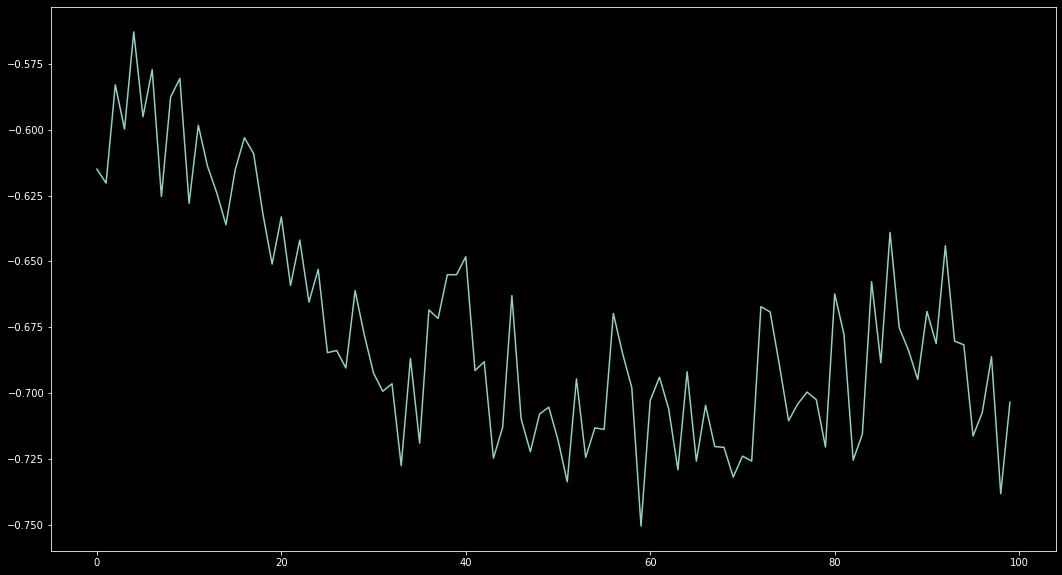

In [18]:
DATASET_FILEPATH = "./Dataset_sentiment_100K_glove_filtered_2g.csv"
df2 = pd.read_csv(OUTPUT_DATASET_FILEPATH, index_col = 0)
fig = plt.figure(figsize=(18, 10))
plt.plot(range(0,100), -1*df2['Bitcoin'].values[:100])

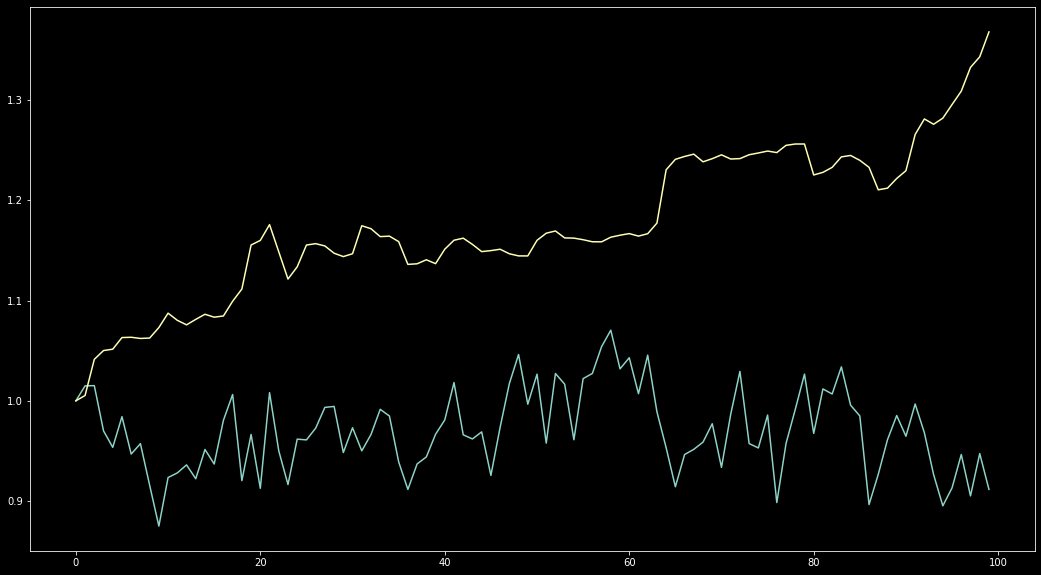

In [21]:
fig = plt.figure(figsize=(18, 10))
x = -df2['Bitcoin'][100:200]
x = x/x[0]
y = df2['Open'][100:200]
y = y/y[0]
plt.plot(range(0,100), x)
plt.plot(range(0,100), y)


In [ ]:
fig = plt.figure(figsize=(18, 10))
plt.plot(range(0,100), df.pct_change()['Open'].values[100:200])

In [ ]:
import random
i = random.randint(0,len(text_data.index))
print(text_data.loc[i]['text'])
print(text_data.loc[i]['sentiment'])

In [ ]:
#BTC price data of the next hour standarized
Y = pd.DataFrame(df['Open']).astype(float)
#Y = dataset_standarization(Y)

#Textual data ('Bitcoin' topic popularity) of the last hour standarized
X = pd.DataFrame(df['Bitcoin']).astype(float)
#X = dataset_standarization(X)
Y.index = X.index

X = sm.add_constant(X)

model = sm.OLS(Y, X, missing = 'drop').fit()

In [ ]:
model.summary()